In [921]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import datetime
from collections import defaultdict

plt.rcParams['figure.figsize'] = (16, 5)

In [922]:
logins = pd.read_json('logins.json')
logins = logins.groupby('login_time').size().to_frame().rename(columns={0:'count'})
logins.head()

,count
login_time,
1970-01-01 20:12:16,1
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:36,1
1970-01-01 20:16:37,1


## Part 1 - Exploratory Data Analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15­minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [923]:
earliest_date = logins.index.min()
latest_date = logins.index.max()

print('The earliest date in this dataset is: {}'.format(earliest_date))
print('The latest date in this dataset is: {}'.format(latest_date))

The earliest date in this dataset is: 1970-01-01 20:12:16
The latest date in this dataset is: 1970-04-13 18:57:38


Aggragate these login counts based on 15 minute time intervals, and visualize and describe the resulting time series of login counts.

In [924]:
logins_resampled = logins.resample('15T').count()

resample_min = logins_resampled.index.min()
resample_max = logins_resampled.index.max()

print('The earliest date in this dataset is: {}'.format(resample_min))
print('The latest date in this dataset is: {}'.format(resample_max))

The earliest date in this dataset is: 1970-01-01 20:00:00
The latest date in this dataset is: 1970-04-13 18:45:00


##### What time are most logins?

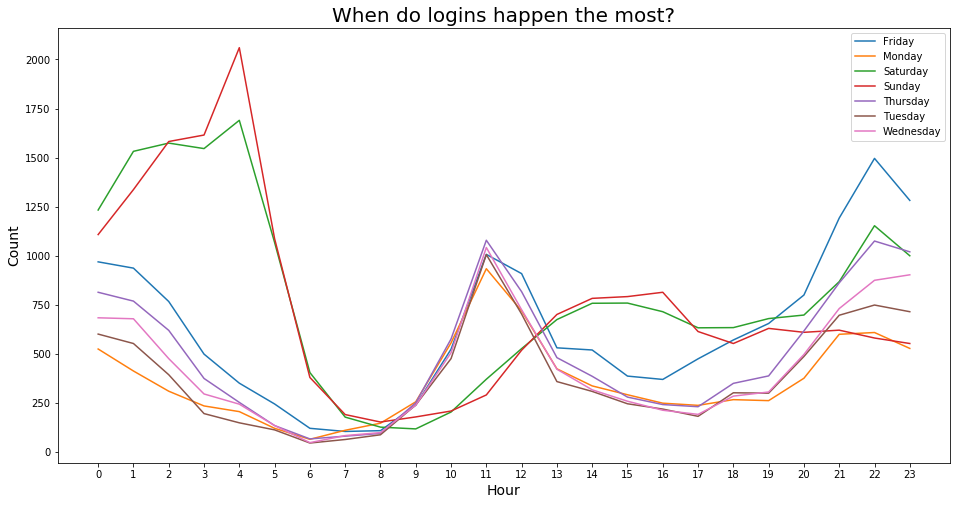

In [925]:
logins_resampled['hour'] = logins_resampled.index.hour
logins_resampled['weekday'] = logins_resampled.index.weekday_name
logins_resampled['minute'] = logins_resampled.index.minute

agg = logins_resampled.groupby(['hour', 'weekday'])['count'].sum().reset_index()

weekday = agg.weekday.unique()

plt.figure(figsize=(16, 8))

for day in weekday:
    df = agg[agg['weekday'] == day]
    plt.plot(df['hour'], df['count'], label=day)

plt.xlabel('Hour', size=14)
plt.xticks(np.arange(24))
plt.ylabel('Count', size=14)
plt.title('When do logins happen the most?', size=20)
plt.legend()

plt.show()

The graph above is a break down of logins per hour of day on x-axis and the number of logins on the y-axis. The lines are colored based on different days of the week.

A few patterns:
* Logins tend to increase significantly on Saturday and Sunday after midnight, up to 4 in the morning, at which time it decreases tremendously.
* During the week, looks like we have two peaks in logins, first around 11a, and the other at around 10p.

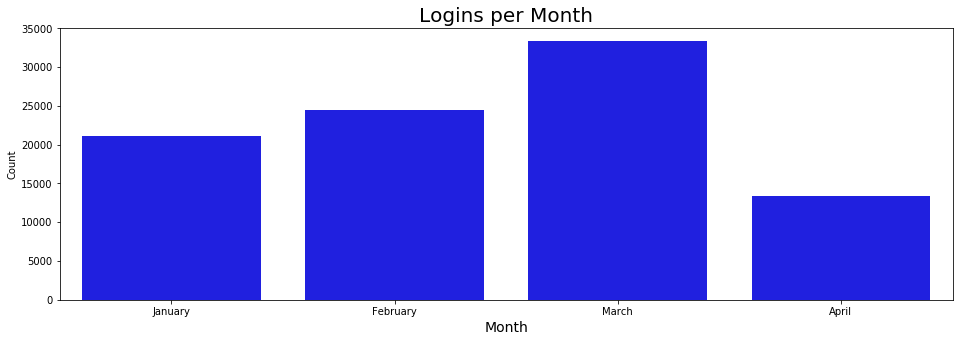

In [926]:
logins_resampled['month'] = logins_resampled.index.month
agg = logins_resampled.groupby('month')['count'].sum().reset_index().rename(columns={0:'count'})

# Plot
sns.barplot(x = 'month', y = 'count', color='b', data=agg)

# Labels
plt.xlabel('Month', size=14)
plt.xticks(np.arange(4), ['January', 'February', 'March', 'April'])
plt.ylabel('Count')
plt.title('Logins per Month', size=20)

# Show Plot
plt.show()

Month over month, there's been a steady increase in logins. Important to note that data in April only goes to April 13th, while we have full month worth of data for the other three months in the dataset.

## Part 2 - Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two-way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
    * a. how you will implement the experiment
    * b. what statistical test(s) you will conduct to verify the significance of the observation
    * c. how you would interpret the results and provide recommendations to the city operations team along with any caveats.

**Answer to Part 2:**

An import clarification that has not been covered in this exercise is what exactly does it mean for driver partners to "be exclusive to each city". I'm thinking of two different possible scenarios:
    * Driver partners start riding in their respective city and refuse to accept rides which will take them across the bridge, since that will subtract from their profit by having to pay the toll out of pocket; or
    * Driver partners are not willing to drive across the bridge to start their rides since it'll cost toll money to get there, thereby reducing the total profit.

I'm assuming the issue is the first one, as the second point I listed above is similar to any employee having to commute to their work place. Emplyees generally pay their way to get to their place of employment. With that laid out, this is how I would approach this exercise:

1. I would measure how often drivers are making cross-city trips. Establish this percentage as a baseline. Then run a pilot program with drivers where toll is 100% reimbursed and measure if there has been an increase in cross-city trips.    
2. I would split the driver partners into two different groups: 
    * a) drivers who do not get reimbursed, and b) drivers who do get reimbursed. Run this test for 30 to 60 days. 
    * At the end of the pilot, compare the two control groups under the null hypotheses that "there is no significant difference in cross-city trips between drivers that get reimbursed for toll costs and drivers who do not get reimbursed for toll costs".
    * Run a t-test and compute the p-value along with confidence intervals. Accept or reject the null hypotheses using the p-value as a guide.
    * Besides the statistical tests above, it's also important to know if the reimbursing toll costs makes financial sense, and not just statistical sense. So I would also want to compare how much money, if any, does this increase the revenue for the company. 

## Part 3 - Predictive modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained **if they were "active" (i.e. took a trip) in the preceding 30 days.**

We would like you to use this dataset to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

1. Perform any cleaning, exploratoy analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of the model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long-term rider retention (again, a few sentences will suffice).

In [927]:
# Read in Dataset

with open('ultimate_data_challenge.json') as f:
    data = json.load(f)
    
df = pd.DataFrame(data)

In [928]:
# Convert dates from object to datetime
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
df['signup_date'] = pd.to_datetime(df['signup_date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


### Fraction of users retained

In [929]:
# When was the most recent trip date? This will be the benchmark to calculate the 30 preceding days
benchmark = df['last_trip_date'].max()
print('The most recent date any user was active in this dataframe is {}'.format(benchmark))

The most recent date any user was active in this dataframe is 2014-07-01 00:00:00


In [930]:
# Add active/inactive column to dataframe
benchmark = df['last_trip_date'].max()
days_30 = datetime.timedelta(days=30)
df['active'] = ((benchmark - df['last_trip_date']) <= days_30).map(lambda x: 'active' if x is True else 'inactive')

# Measure percentage of users retained
total = len(df)
pct_retained = (df.active.value_counts()/total)[1]
count_retained = df.active.value_counts()[1]

print('Out of {} users who signed up for the service, {} are still active, or {:2.2%}'\
      .format(total, count_retained, pct_retained))

Out of 50000 users who signed up for the service, 18804 are still active, or 37.61%


### EDA

In [931]:
# How many users signed-up and had their last ride on the same day?
sameday_count = 0
driver_rating_dict = defaultdict(list)

for index, row in df.iterrows():
    if row['last_trip_date'] == row['signup_date']:
        sameday_count += 1
        driver_rating_dict[index].append(row['avg_rating_of_driver'])


print('{:2.2%} of all users signed-up and had their last ride on the same day'.format(sameday_count/total))

4.60% of all users signed-up and had their last ride on the same day


In [932]:
driver_rating_dict

defaultdict(list,
            {71: [5.0],
             95: [nan],
             162: [5.0],
             187: [5.0],
             191: [nan],
             215: [nan],
             230: [1.0],
             238: [nan],
             271: [nan],
             291: [5.0],
             298: [5.0],
             334: [nan],
             399: [4.5],
             415: [5.0],
             425: [nan],
             463: [nan],
             471: [5.0],
             540: [5.0],
             544: [5.0],
             577: [3.0],
             579: [4.0],
             616: [5.0],
             650: [4.0],
             654: [5.0],
             662: [nan],
             668: [5.0],
             698: [5.0],
             749: [5.0],
             781: [5.0],
             803: [4.0],
             813: [nan],
             815: [2.0],
             865: [5.0],
             907: [nan],
             908: [nan],
             915: [nan],
             924: [5.0],
             934: [5.0],
             941: [5.0],
         

### Compare statistics between active users and inactive users

In [933]:
# Out of the active and inactive users, how many trips did each group take in the first 30 days?
active_df = df[df['active'] == 'active']
inactive_df = df[df['active'] == 'inactive']

active_first30days_mean = np.mean(active_df['trips_in_first_30_days'])
inactive_first30days_mean = np.mean(inactive_df['trips_in_first_30_days'])

print('Active users average number of rides in the first 30 days: {:2.2f} trips'.format(active_first30days_mean))
print('Inactive users average number of rides in the first 30 days: {:2.2f} trips'.format(inactive_first30days_mean))

Active users average number of rides in the first 30 days: 3.31 trips
Inactive users average number of rides in the first 30 days: 1.66 trips


In comparing the active users with the inactive users, most categories above are similar, except for trips in the first 30 days, where active users took around twice as many trips as non-active users, on average.

In [934]:
# What is the city signup distribution?
cities_agg = df.groupby('city').size().reset_index().rename(columns={0:'count'})
cities_agg['pct'] = (cities_agg['count'] / total) * 100
print('All Data')
print(cities_agg)
print('===================================')
city_active = active_df.groupby('city').size().reset_index().rename(columns={0:'count'})
city_active['pct'] = (city_active['count'] / cities_agg['count'])*100
print('Active')
print(city_active)
print('===================================')
city_inactive = inactive_df.groupby('city').size().reset_index().rename(columns={0:'count'})
city_inactive['pct'] = (city_inactive['count'] / cities_agg['count'])*100
print('Inactive')
print(city_inactive)

All Data
             city  count     pct
0         Astapor  16534  33.068
1  King's Landing  10130  20.260
2      Winterfell  23336  46.672
Active
             city  count        pct
0         Astapor   4228  25.571550
1  King's Landing   6363  62.813425
2      Winterfell   8213  35.194549
Inactive
             city  count        pct
0         Astapor  12306  74.428450
1  King's Landing   3767  37.186575
2      Winterfell  15123  64.805451


Percentages Under active and inactive represent active / all data or inactive / all data.

From the tables above, we can tell that as a percentage of the total users **King's Landing** has a much higher retention rate from their users compared to Astapor and Winterfell.

In [935]:
aggragator = ['trips_in_first_30_days', 'avg_dist', 'surge_pct', 'weekday_pct', 'ultimate_black_user']
# What is the city signup distribution?
cities_agg = df.groupby('city')[aggragator].mean().reset_index()
print('All Data')
print(cities_agg)
print('===========================================================================')
city_active = active_df.groupby('city')[aggragator].mean().reset_index()
print('Active')
print(city_active)
print('===========================================================================')
city_inactive = inactive_df.groupby('city')[aggragator].mean().reset_index()
print('Inactive')
print(city_inactive)

All Data
             city  trips_in_first_30_days  avg_dist  surge_pct  weekday_pct  \
0         Astapor                1.948651  5.427940  10.140305    60.370050   
1  King's Landing                2.463672  5.976596   9.966979    63.232290   
2      Winterfell                2.431179  5.980153   7.449927    60.318936   

   ultimate_black_user  
0             0.391738  
1             0.415202  
2             0.350146  
Active
             city  trips_in_first_30_days  avg_dist  surge_pct  weekday_pct  \
0         Astapor                2.969726  4.424487   9.803500    60.376656   
1  King's Landing                2.923149  5.500464  10.514223    63.592472   
2      Winterfell                3.776452  5.171350   7.763059    60.203093   

   ultimate_black_user  
0             0.564570  
1             0.507779  
2             0.472300  
Inactive
             city  trips_in_first_30_days  avg_dist  surge_pct  weekday_pct  \
0         Astapor                1.597838  5.772699  10.256021

From the data summary above, we can conclude the following:
* Users who are still active tend to take shorter trips on average on their first 30 days.
* Users who are still active also tend to be about twice as active in the first 30 days when compared to inactive users.
* Users who are still active took Ultimate Black rides in the first 30 days when compared to users who are inactive
* There is not clear conclusion from weekday percentage and surge percentage as how that impacts if a user is still active or not.
* **King's Landing** has a higher retention rate when compared to the other two cities. It is worth speaking with management to see if King's Landing is doing anything different.

In [936]:
# # What is phone usage distribution?
# phone_agg = df.groupby('phone').size().reset_index().rename(columns={0:'count'})
# phone_agg['pct'] = (phone_agg['count'] / total) * 100
# print('All Data')
# print(phone_agg)
# print()
active_phone_agg = active_df.groupby('phone').size().reset_index().rename(columns={0:'count'})
active_phone_agg['pct'] = (active_phone_agg['count'] / phone_agg['count']) * 100
print('============================')
print('Active')
print(active_phone_agg)
print()
inactive_phone_agg = inactive_df.groupby('phone').size().reset_index().rename(columns={0:'count'})
inactive_phone_agg['pct'] = (inactive_phone_agg['count'] / phone_agg['count']) * 100
print('============================')
print('Inactive')
print(inactive_phone_agg)

Active
     phone  count        pct
0  Android   3146  20.942617
1   iPhone  15525  44.893297

Inactive
     phone  count        pct
0  Android  11876  79.057383
1   iPhone  19057  55.106703


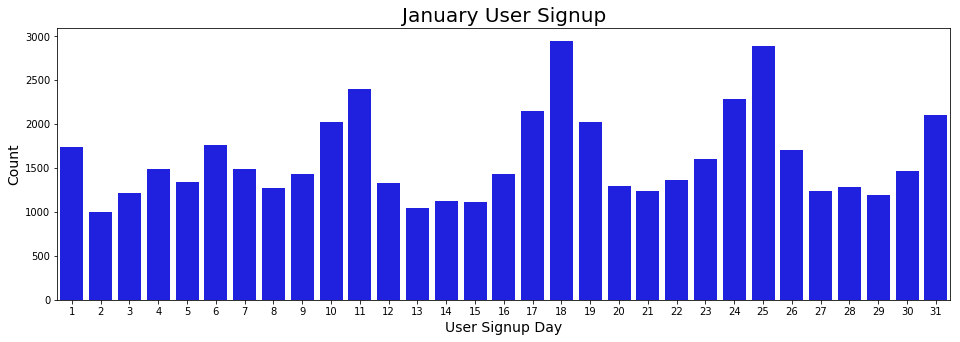

In [937]:
sns.countplot(x = 'signup_date', color='b', data=df)
plt.xlabel('User Signup Day', size=14)
plt.xticks(np.arange(0, 31), np.arange(1, 32))
plt.ylabel('Count', size=14)
plt.title('January User Signup', size=20)
plt.show()

In [938]:
time = pd.DatetimeIndex(df['signup_date'])
time_active = pd.DatetimeIndex(active_df['signup_date'])
time_inactive = pd.DatetimeIndex(inactive_df['signup_date'])

df['weekday'] = time.weekday_name
agg = df.groupby('weekday').size().reset_index().rename(columns={0:'count'})
agg['pct'] = agg['count'] / sum(agg['count']) * 100
print('All Data')
print(agg)
print('==============================')
active_df['weekday'] = time_active.weekday_name
active_agg = active_df.groupby('weekday').size().reset_index().rename(columns={0:'count'})
active_agg['pct'] = (active_agg['count'] / agg['count']) * 100
print('Active')
print(active_agg)
print('==============================')
inactive_df['weekday'] = time_inactive.weekday_name
inactive_agg = inactive_df.groupby('weekday').size().reset_index().rename(columns={0:'count'})
inactive_agg['pct'] = (inactive_agg['count'] / agg['count']) * 100
print('Inactive')
print(inactive_agg)

All Data
     weekday  count     pct
0     Friday   9767  19.534
1     Monday   5343  10.686
2   Saturday   9720  19.440
3     Sunday   6413  12.826
4   Thursday   6945  13.890
5    Tuesday   5124  10.248
6  Wednesday   6688  13.376
Active
     weekday  count        pct
0     Friday   3619  37.053343
1     Monday   2073  38.798428
2   Saturday   3698  38.045267
3     Sunday   2467  38.468735
4   Thursday   2501  36.011519
5    Tuesday   1927  37.607338
6  Wednesday   2519  37.664474
Inactive
     weekday  count        pct
0     Friday   6148  62.946657
1     Monday   3270  61.201572
2   Saturday   6022  61.954733
3     Sunday   3946  61.531265
4   Thursday   4444  63.988481
5    Tuesday   3197  62.392662
6  Wednesday   4169  62.335526


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Predictive Model

In [939]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
from sklearn import decomposition, metrics
from sklearn.preprocessing import MinMaxScaler

#### Build a predictive model of user retention

In [940]:
# Set model baseline
print('For this dataset, {:2.2%} of users are still active. This will the model\'s baseline.'\
      .format(pct_retained))

For this dataset, 37.61% of users are still active. This will the model's baseline.


In [941]:
# Convert city to integer
city_dict = {'Astapor':1, 'King\'s Landing':2, 'Winterfell':3}
df['cities'] = df['city'].map(lambda x: city_dict[x])

# Convert weekday to integer
weekday_dict = {'Monday':1, 'Tuesday':2, 'Wednesday':3, 'Thursday':4, 'Friday':5, 'Saturday':6, 'Sunday':7}
df['day_of_week'] = df['weekday'].map(lambda x: weekday_dict[x])

In [942]:
# Select features to use
chosen_ones = ['avg_dist', 'avg_surge', 'trips_in_first_30_days','cities','ultimate_black_user']

# Set model Features and Labels
feature = df[chosen_ones]
label = df['active']

In [943]:
feature.shape

(50000, 5)

In [944]:
label.value_counts()

inactive    31196
active      18804
Name: active, dtype: int64

#### Run models and check accuracy

LinearSVC

In [945]:
linear = LinearSVC()

X_train, X_test, y_train, y_test = train_test_split(feature,
                                                    label,
                                                    random_state=4)

linear.fit(X_train, y_train)
y_pred = linear.predict(X_test)

In [946]:
print(metrics.classification_report(y_test, y_pred))

             precision    recall  f1-score   support

     active       0.52      0.48      0.50      4672
   inactive       0.70      0.74      0.72      7828

avg / total       0.64      0.64      0.64     12500



In [947]:
# Linear SVC with GridSearchCV
X_test, X_train, y_test, y_train = train_test_split(feature,
                                                    label,
                                                    test_size = 0.3,
                                                    random_state = 4)

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(LinearSVC(), param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)

print('Best cross_validation score: {:.2f}'.format(grid.best_score_))
print('Best parameters: ', grid.best_params_)

Best cross_validation score: 0.67
Best parameters:  {'C': 0.001}


Logistic Regression

In [948]:
logistic = LogisticRegression()

X_train, X_test, y_train, y_test = train_test_split(feature,
                                                    label,
                                                    random_state=4)

logistic.fit(X_train, y_train)
y_pred = logistic.predict(X_test)

In [949]:
print(metrics.classification_report(y_test, y_pred))

             precision    recall  f1-score   support

     active       0.61      0.31      0.41      4672
   inactive       0.68      0.88      0.77      7828

avg / total       0.66      0.67      0.63     12500



In [950]:
# Logistic Regression with GridSearchCV
X_test, X_train, y_test, y_train = train_test_split(feature,
                                                    label,
                                                    test_size = 0.3,
                                                    random_state = 4)

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(LogisticRegression(), param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)

print('Best cross_validation score: {:.2f}'.format(grid.best_score_))
print('Best parameters: ', grid.best_params_)

Best cross_validation score: 0.67
Best parameters:  {'C': 0.01}


Random Forest

In [951]:
forest = RandomForestClassifier()

X_train, X_test, y_train, y_test = train_test_split(feature,
                                                    label,
                                                    random_state=4)

forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)

In [952]:
print(metrics.classification_report(y_test, y_pred))

             precision    recall  f1-score   support

     active       0.57      0.60      0.58      4672
   inactive       0.75      0.73      0.74      7828

avg / total       0.68      0.68      0.68     12500



In [953]:
# Random Forest Classifier with GridSearchCV
X_test, X_train, y_test, y_train = train_test_split(feature,
                                                    label,
                                                    test_size = 0.3,
                                                    random_state = 4)

param_grid = {'n_estimators': [1, 3, 5, 10, 15, 20]}
grid = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)

print('Best cross_validation score: {:.2f}'.format(grid.best_score_))
print('Best parameters: ', grid.best_params_)

Best cross_validation score: 0.69
Best parameters:  {'n_estimators': 15}


Feature Importance

In [957]:
# Based on the three models run above, the best performing model is Random Forest, though not by much. Let's use Random Forest to move forward in this exercise
feature_names = ['avg_dist', 'avg_surge', 'trips_1st_30_days','cities','ultimate_black']
print('Feature Importance')
print('-----------------------------')
for index, value in enumerate(forest.feature_importances_):
    print('{:20}{:3f}'.format(feature_names[index], value))


Feature Importance
-----------------------------
avg_dist            0.603343
avg_surge           0.172840
trips_1st_30_days   0.104877
cities              0.075988
ultimate_black      0.042952


Model is predicting user retention with 68% accuracy. One important piece of information found through EDA is rider retention in the city of King's Landing is much higher when compared to the two other cities. Another step I would take to improve this model is to speak with management from King's Landing to see what, if anything, they are doing differently when compared to the other two cities in this dataset. I suspect there's important metrics they are using to improve retention.